In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade
import fov
import pickle
import matplotlib
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.path
import matplotlib.patches 
import numpy as np
from scipy import interpolate
import plottingfunctions

In [2]:
with open('radar_data.pickle', 'rb') as f:
    [bks, fhe, fhw, cve, cvw] = pickle.load(f)
df = pd.read_pickle('storm_tec.pkl')


C:\Users\Ian\anaconda3\envs\env\lib\site-packages\cartopy\mpl\gridliner.py: 307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
C:\Users\Ian\anaconda3\envs\env\lib\site-packages\cartopy\mpl\gridliner.py: 343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.


_HdwInfo(stid=207, abbrev='cve', geographic=_Coord(lat=43.271, lon=-120.358, alt=1313.535), boresight=54.0, beam_separation=3.24, velocity_sign=1.0, rx_attenuator=10.0, tdiff=-0.398, phase_sign=1.0, interferometer_offset=_InterferometerOffset(x=0.0, y=-80.0, z=0.0), rx_rise_time=0.0, attenuation_stages=0.0, gates=110, beams=24)


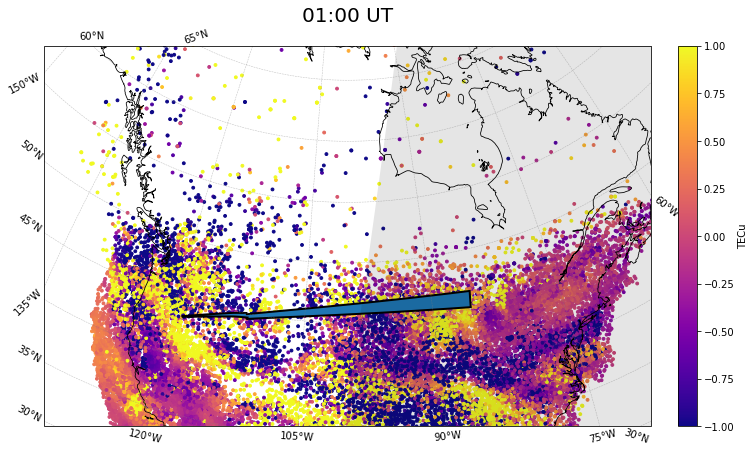

In [3]:
ax = plottingfunctions.single_plot(dt.datetime(2017, 9, 8, 1), df)
start = dt.datetime(2017, 9, 7, 23)
end = dt.datetime(2017, 9, 8, 3)
radar = 'cve'
beam = 18
path, interp = plottingfunctions.get_outline(radar, beam)
patch = matplotlib.patches.PathPatch(path, edgecolor='k', lw=2, transform=ccrs.PlateCarree())
ax.add_patch(patch)



part = df[df['datetime'] == dt.datetime(2017, 9, 8, 1)]
df['contained'] = path.contains_points(np.vstack((df.glon, df.gdlat)).T)

_HdwInfo(stid=207, abbrev='cve', geographic=_Coord(lat=43.271, lon=-120.358, alt=1313.535), boresight=54.0, beam_separation=3.24, velocity_sign=1.0, rx_attenuator=10.0, tdiff=-0.398, phase_sign=1.0, interferometer_offset=_InterferometerOffset(x=0.0, y=-80.0, z=0.0), rx_rise_time=0.0, attenuation_stages=0.0, gates=110, beams=24)


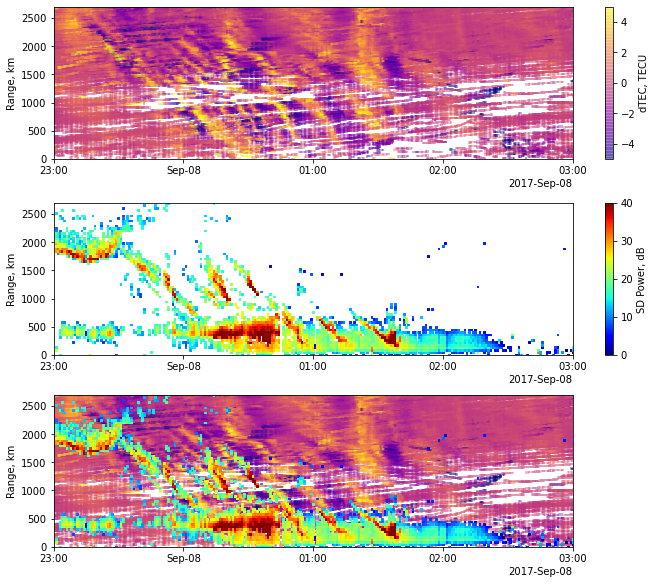

In [4]:

rad_df = pd.read_pickle('radar_2017-09-07cve18.pkl')
plottingfunctions.threeplot('cve', 18, rad_df, df, start, end)

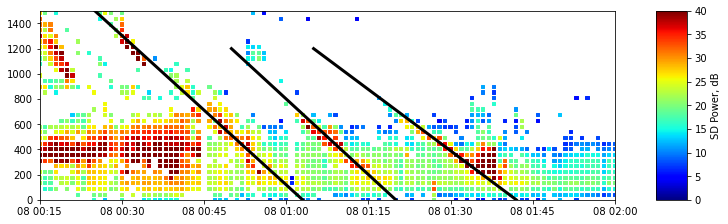

In [122]:
def annotate(rad_df, startrange, endrange, start, end):
    import pandas as pd
    import matplotlib.pyplot as plt

    rad_df.slist = rad_df.slist * 45
  
    fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 3))
    a1 = axs.scatter(rad_df.time, rad_df.slist, c = rad_df.p_l, vmin = 0, vmax=40, cmap='jet', marker = 's', s=10)
 

    #formatting
    cbar = fig.colorbar(a1) 
    cbar.set_label('SD Power, dB') 
    axs.set_xlim([start, end])
    axs.set_ylim([startrange, endrange])

    #annotations
    #line 1
    x1, y1 = [dt.datetime(2017, 9, 8, 0, 20), dt.datetime(2017, 9, 8, 1, 3)], [1700, 0]
    x2, y2 = [dt.datetime(2017, 9, 8, 0, 50), dt.datetime(2017, 9, 8, 1, 20)], [1200, 0]
    x3, y3 = [dt.datetime(2017, 9, 8, 1, 5), dt.datetime(2017, 9, 8, 1, 42)], [1200, 0]
    plt.plot(x1, y1, c='k', linewidth = 3)
    plt.plot(x2, y2, c='k', linewidth = 3)
    plt.plot(x3, y3, c='k', linewidth = 3)


rad_df = pd.read_pickle('radar_2017-09-07cve18.pkl')
annotate(rad_df, 0, 1500,  dt.datetime(2017, 9, 8, 0, 15),  dt.datetime(2017, 9, 8, 2))

_HdwInfo(stid=207, abbrev='cve', geographic=_Coord(lat=43.271, lon=-120.358, alt=1313.535), boresight=54.0, beam_separation=3.24, velocity_sign=1.0, rx_attenuator=10.0, tdiff=-0.398, phase_sign=1.0, interferometer_offset=_InterferometerOffset(x=0.0, y=-80.0, z=0.0), rx_rise_time=0.0, attenuation_stages=0.0, gates=110, beams=24)
p=-0.33464561941012566


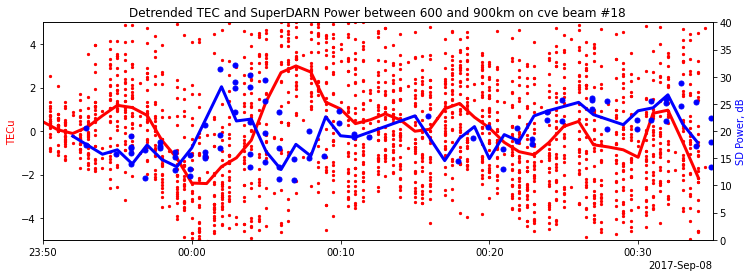

In [133]:
def vel_ts(radar, beam, rad_df, tec_df, startrange, endrange, start, end):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    import numpy as np

    #getting just the TEC in desired beam, and adding range data
    path, interp = plottingfunctions.get_outline(radar, beam)
    tec_df['contained'] = path.contains_points(np.vstack((tec_df.glon, tec_df.gdlat)).T) 
    part = tec_df.where(tec_df['contained'] == 1).dropna()
    part['nrange'] = 45*interp(part.glon, part.gdlat)  
    part = part.where(part['datetime'] < end)
    part = part.where(part['datetime'] > start)
    part = part.where(startrange < part.nrange)
    part = part.where(part.nrange < endrange).dropna()

    #getting SD data only within certain times and ranges
    rad_df.slist = rad_df.slist * 45
    rad_df = rad_df.where(rad_df['time'] < end)
    rad_df = rad_df.where(rad_df['time'] > start)
    rad_df = rad_df.where(rad_df['slist'] < endrange)
    rad_df = rad_df.where(rad_df['slist'] > startrange).dropna()

    #plotting
    fig, ax = plt.subplots(figsize=(12, 4))

    #TEC
    ax.scatter(part.datetime, part['30min_detrend'], s=5, c='r')
    grouped = part.set_index('datetime').groupby(pd.Grouper(freq='min')).mean().dropna()
    ax.plot(grouped.index, grouped['30min_detrend'], c='r', linewidth=3)
    ax.set_ylim([-5, 5])

    #SuperDARN on same axes, labels on right
    twin1 = ax.twinx()
    twin1.scatter(rad_df.time, rad_df.p_l, c='b', s=25)
    rad_grouped = rad_df.set_index('time').groupby(pd.Grouper(freq='min')).mean().dropna()
    twin1.plot(rad_grouped.index, rad_grouped.p_l, c='b', linewidth=3)
    twin1.set_ylim([0, 40])

    #plot formatting
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.title('Detrended TEC and SuperDARN Power between ' + str(startrange) + ' and ' + str(endrange) +'km on ' + radar + ' beam #' + str(beam))
    ax.set_xlim([start, end])
    twin1.set_xlim([start, end])

    #correlation
    print('p=' + str(grouped['30min_detrend'].corr(rad_grouped.p_l)))
    #ylabels
    ax.set_ylabel('TECu')
    twin1.set_ylabel('SD Power, dB')
    ax.yaxis.label.set_color('r')
    twin1.yaxis.label.set_color('b')
    plt.show()


rad_df = pd.read_pickle('radar_2017-09-07cve18.pkl')
vel_ts(radar, beam, rad_df, df, 600, 900, dt.datetime(2017, 9, 7, 23, 50), dt.datetime(2017, 9, 8, 0, 35))

Text(0, 0.5, 'Slant Range, km')

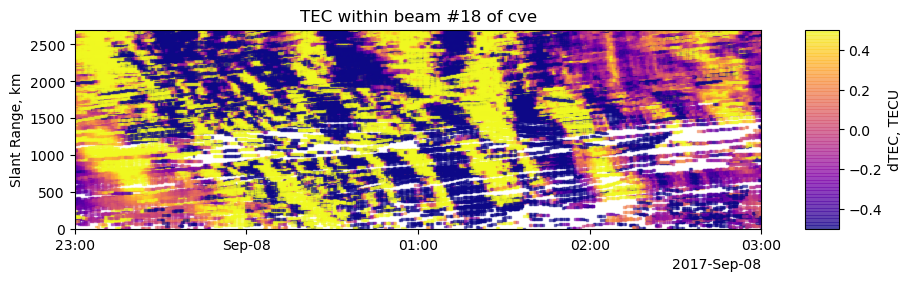

In [ ]:
part = df.where(df['contained'] == 1).dropna()

part['nrange'] = 45*interp(part.glon, part.gdlat)
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(9, 2.7))
a1 = pts = axs.scatter(part.datetime, part.nrange, c=part['30min_detrend'], vmin=-.5, vmax=.5, marker='s', alpha=.5, s=2, cmap='plasma')
cbar = fig.colorbar(a1)
cbar.set_label('dTEC, TECU')
matplotlib.rcParams['figure.dpi'] = 300
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)
axs.set_xlim([start, end])
axs.set_ylim([0, 2700])
plt.title('TEC within beam #' + str(beam) + ' of ' + radar)
axs.set_ylabel("Slant Range, km")

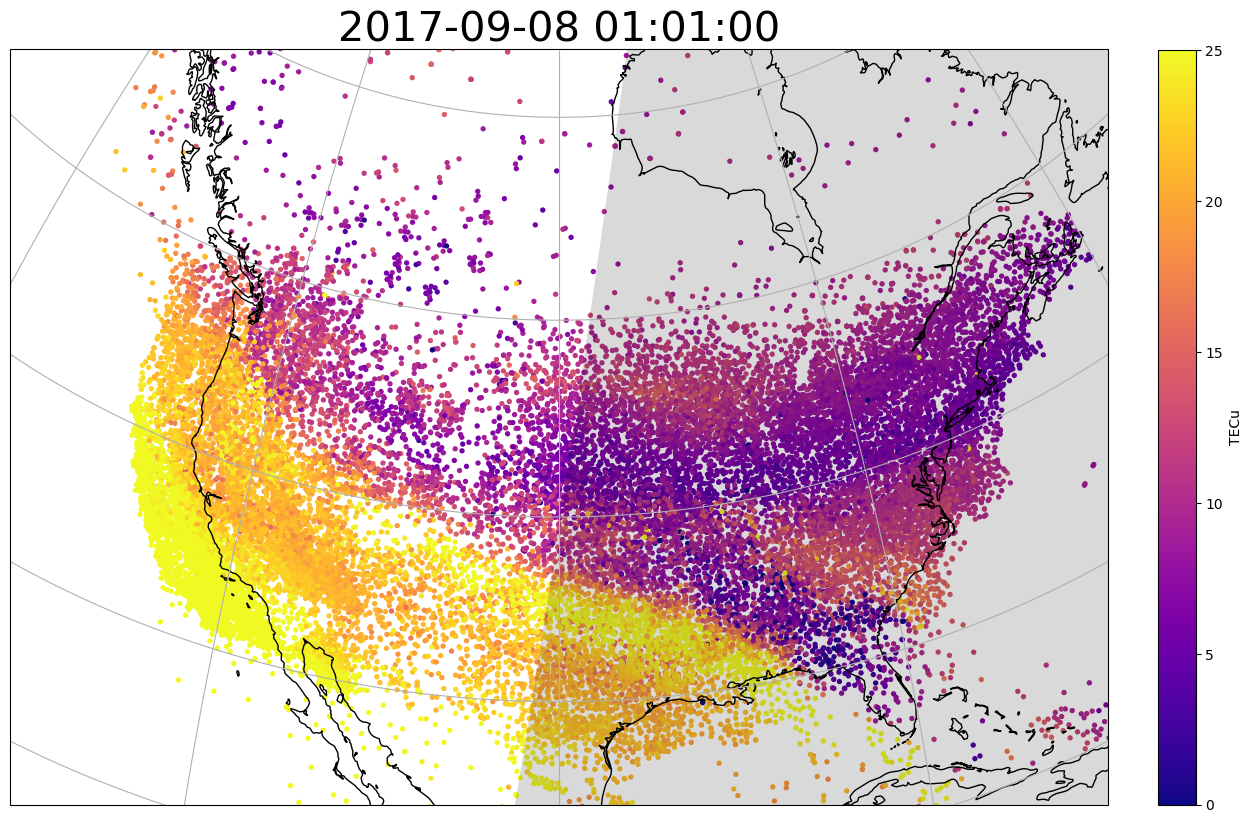

In [ ]:

tecmap = plt.figure(figsize=(16, 10))
time = dt.datetime(2017, 9, 8, 1, 1)
ax = plt.axes(projection = ccrs.Orthographic(central_longitude=-100, central_latitude=60))
ax.coastlines(color='black', zorder=1)
ax.gridlines()
ax.set_extent([-130, -70, 20, 60])
ax.add_feature(Nightshade(time, alpha=0.15))
   
part = df[df['datetime'] == time]

        
ax.set_title(str(time), size=30)    
mesh = ax.scatter(part.glon, part.gdlat, c=part.tec, transform=ccrs.PlateCarree(), vmin=0, vmax=25, cmap='plasma', s=8)
cbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
cbar.set_label('TECu')

plt.show()